# Logistic Regression from scratch

In [1]:
!pip3 install matplotlib

In [2]:
from random import random
from copy import deepcopy
from math import exp, log, sqrt
from pathlib import Path
from matplotlib import pyplot as plt
from typing import List

In [3]:
# Ensure that we have a `data` directory we use to store downloaded data
!mkdir -p data
data_dir: Path = Path('data')

In [4]:
# Downloading the "Marks" data set (source: https://github.com/animesh-agarwal/Machine-Learning)
!wget -nc -P data https://raw.githubusercontent.com/animesh-agarwal/Machine-Learning/5b2d8a71984016ae021094641a3815d6ea9ac527/LogisticRegression/data/marks.txt

--2020-02-20 18:21:14--  https://raw.githubusercontent.com/animesh-agarwal/Machine-Learning/5b2d8a71984016ae021094641a3815d6ea9ac527/LogisticRegression/data/marks.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3775 (3.7K) [text/plain]
Saving to: ‘data/marks.txt’

marks.txt           100%[===================>]   3.69K  --.-KB/s    in 0.002s  

2020-02-20 18:21:15 (1.81 MB/s) - ‘data/marks.txt’ saved [3775/3775]



In [5]:
!head -n 20 data/marks.txt

34.62365962451697,78.0246928153624,0
30.28671076822607,43.89499752400101,0
35.84740876993872,72.90219802708364,0
60.18259938620976,86.30855209546826,1
79.0327360507101,75.3443764369103,1
45.08327747668339,56.3163717815305,0
61.10666453684766,96.51142588489624,1
75.02474556738889,46.55401354116538,1
76.09878670226257,87.42056971926803,1
84.43281996120035,43.53339331072109,1
95.86155507093572,38.22527805795094,0
75.01365838958247,30.60326323428011,0
82.30705337399482,76.48196330235604,1
69.36458875970939,97.71869196188608,1
39.53833914367223,76.03681085115882,0
53.9710521485623,89.20735013750205,1
69.07014406283025,52.74046973016765,1
67.94685547711617,46.67857410673128,0
70.66150955499435,92.92713789364831,1
76.97878372747498,47.57596364975532,1


In [6]:
# Create the Python path pointing to the `marks.txt` file
marks_data_path: Path = data_dir / 'marks.txt'

In [7]:
# Turn the data into a list of x vectors (one for every pair of x items) and a vector containing all the y items
xs: List[List[float]] = []
ys: List[float] = []

with open(marks_data_path) as file:
    for line in file:
        data_point: List[str] = line.strip().split(',')
        x1: float = float(data_point[0])
        x2: float = float(data_point[1])
        y: int = int(data_point[2])
        xs.append([x1, x2])
        ys.append(y)

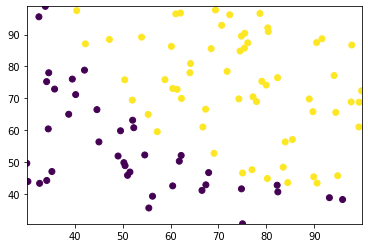

In [8]:
# Create a scatter plot with the x1 values on the x axis and the x2 values on the y axis
# The color is determined by the corresponding y value
x1s: List[float] = [x[0] for x in xs]
x2s: List[float] = [x[1] for x in xs]

plt.scatter(x1s, x2s, c=ys)
plt.axis([min(x1s), max(x1s), min(x2s), max(x2s)]);

In [9]:
# Prepend a constant of 1 to every x value so that we can use the dot product later on
for x in xs:
    x.insert(0, 1)

xs[:5]

[[1, 34.62365962451697, 78.0246928153624],
 [1, 30.28671076822607, 43.89499752400101],
 [1, 35.84740876993872, 72.90219802708364],
 [1, 60.18259938620976, 86.30855209546826],
 [1, 79.0327360507101, 75.3443764369103]]

In [10]:
# Rescales the data so that each item has a mean of 0 and a standard deviation of 1
# See: https://en.wikipedia.org/wiki/Standard_score
def z_score(data: List[List[float]]) -> List[List[float]]:
    def mean(data: List[float]) -> float:
        return sum(data) / len(data)

    def standard_deviation_sample(data: List[float]) -> float:
        num_items: int = len(data)
        mu: float = mean(data)
        return sqrt(1 / (num_items - 1) * sum([(item - mu) ** 2 for item in data]))

    data_copy: List[List[float]] = deepcopy(data)
    data_transposed = list(zip(*data_copy))
    mus: List[float] = []
    stds: List[float] = []
    for item in data_transposed:
        mus.append(mean(list(item)))
        stds.append(standard_deviation_sample(list(item)))

    for item in data_copy:
        mu: float = mean(item)
        std: float = standard_deviation_sample(item)
        for i, elem in enumerate(item):
            if stds[i] > 0.0:
                item[i] = (elem - mus[i]) / stds[i]

    return data_copy

In [11]:
xs = z_score(xs)

xs[:5]

[[1, -1.5942162646576388, 0.6351413941754435],
 [1, -1.8171014180340745, -1.2014885239142388],
 [1, -1.531325157335502, 0.3594832875590465],
 [1, -0.28068723821760927, 1.0809228071415948],
 [1, 0.6880619310375534, 0.4909048515228952]]

In [12]:
# The sigmoid function which turns any number `x` into a number between 0 and 1
def sigmoid(x: float) -> float:
    return 1 / (1 + exp(-x))

assert sigmoid(0) == 0.5

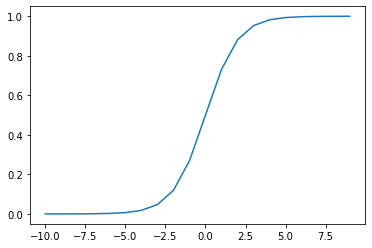

In [13]:
xs_sigmoid: List[float] = [x for x in range(-10, 10)]
ys_sigmoid: List[float] = [sigmoid(x) for x in xs_sigmoid]

plt.plot(xs_sigmoid, ys_sigmoid);

In [14]:
# Function which calculates the dot product
# See: https://en.wikipedia.org/wiki/Dot_product
def dot(a: List[float], b: List[float]) -> float:
    assert len(a) == len(b)
    return sum([a_i * b_i for a_i, b_i in zip(a, b)])

assert dot([1, 2, 3, 4], [5, 6, 7, 8]) == 70

In [15]:
# Function which turns vectors of `beta` and `x` values into a value between 0 and 1
def squish(beta: List[float], x: List[float]) -> float:
    assert len(beta) == len(x)
    # Calculate the dot product
    dot_result: float = dot(beta, x)
    # Use sigmoid to get a result between 0 and 1
    return sigmoid(dot_result)

assert squish([1, 2, 3, 4], [5, 6, 7, 8]) == 1.0

In [16]:
# The negative log likelihood function which we'll use to calculate how "off" our prediction is
def neg_log_likelihood(y: float, y_pred: float) -> float:
    return -((y * log(y_pred)) + ((1 - y) * log(1 - y_pred)))

assert 2.30 < neg_log_likelihood(1, 0.1) < 2.31
assert 2.30 < neg_log_likelihood(0, 0.9) < 2.31
assert 0.10 < neg_log_likelihood(1, 0.9) < 0.11
assert 0.10 < neg_log_likelihood(0, 0.1) < 0.11

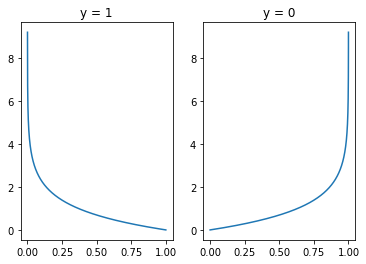

In [17]:
# Plot of the negative log likelihood function to see how incorrect predictions influence the overall error
xs_nll: List[float] = [x / 10000 for x in range(1, 10000)]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(xs_nll, [neg_log_likelihood(1, x) for x in xs_nll])
ax1.set_title('y = 1')
ax2.plot(xs_nll, [neg_log_likelihood(0, x) for x in xs_nll])
ax2.set_title('y = 0');

In [18]:
# Calculates the overall error
def error(ys: List[float], ys_pred: List[float]) -> float:
    assert len(ys) == len(ys_pred)
    num_items: int = len(ys)
    sum_nll: float = sum([neg_log_likelihood(y, y_pred) for y, y_pred in zip(ys, ys_pred)])
    return (1 / num_items) * sum_nll

assert 2.30 < error([1], [0.1]) < 2.31
assert 2.30 < error([0], [0.9]) < 2.31
assert 0.10 < error([1], [0.9]) < 0.11
assert 0.10 < error([0], [0.1]) < 0.11

In [19]:
# Find the best separation to classify the data points
beta: List[float] = [random() / 10 for _ in range(3)]

print(f'Starting with "beta": {beta}')

epochs: int = 5000
learning_rate: float = 0.01

for epoch in range(epochs):
    # Calculate the "predictions" (squishified dot product of `beta` and `x`) based on our current `beta` vector
    ys_pred: List[float] = [squish(beta, x) for x in xs]

    # Calculate and print the error
    if epoch % 1000 == True:
        loss: float = error(ys, ys_pred)
        print(f'Epoch {epoch} --> loss: {loss}')

    # Calculate the gradient
    grad: List[float] = [0 for _ in range(len(beta))]
    for x, y in zip(xs, ys):
        err: float = squish(beta, x) - y
        for i, x_i in enumerate(x):
            grad[i] += (err * x_i)
    grad = [1 / len(x) * g_i for g_i in grad]

    # Take a small step in the direction of greatest decrease
    beta = [b + (gb * -learning_rate) for b, gb in zip(beta, grad)]

print(f'Best estimate for "beta": {beta}')

Starting with "beta": [0.06879018957747185, 0.060750489548129484, 0.08122488791609535]
Epoch 1 --> loss: 0.6091560801945126
Epoch 1001 --> loss: 0.2037432848849053
Epoch 2001 --> loss: 0.20350230881468107
Epoch 3001 --> loss: 0.20349779972872906
Epoch 4001 --> loss: 0.20349770371660023
Best estimate for "beta": [1.7184091311489376, 4.01281584290694, 3.7438191715393083]


In [20]:
# Compute some statistics to see how our model is doing
total: int = len(ys)
thresh: float = 0.5
true_positives: int = 0
true_negatives: int = 0
false_positives: int = 0
false_negatives: int = 0
for i, x in enumerate(xs):
    y: int = ys[i]
    pred: float = squish(beta, x)
    y_pred: int = 1
    if pred < thresh:
        y_pred = 0
    if y == 1 and y_pred == 1:
        true_positives += 1
    elif y == 0 and y_pred == 0:
        true_negatives += 1
    elif y == 1 and y_pred == 0:
        false_negatives += 1
    elif y == 0 and y_pred == 1:
        false_positives += 1

print(f'True Positives: {true_positives}')
print(f'True Negatives: {true_negatives}')
print(f'False Positives: {false_positives}')
print(f'False Negatives: {false_negatives}')
print(f'Accuracy: {(true_positives + true_negatives) / total}')
print(f'Error rate: {(false_positives + false_negatives) / total}')

True Positives: 55
True Negatives: 34
False Positives: 6
False Negatives: 5
Accuracy: 0.89
Error rate: 0.11


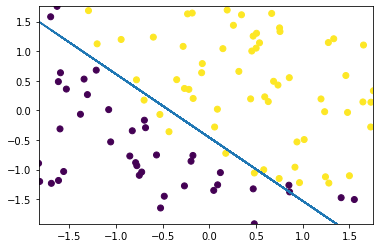

In [21]:
# Plot the decision boundary
x1s: List[float] = [x[1] for x in xs]
x2s: List[float] = [x[2] for x in xs]
plt.scatter(x1s, x2s, c=ys)
plt.axis([min(x1s), max(x1s), min(x2s), max(x2s)]);

m: float = -(beta[1] / beta[2])
b: float = -(beta[0] / beta[2])

x2s: List[float] = [m * x[1] + b for x in xs]

plt.plot(x1s, x2s, '--');